<a href="https://colab.research.google.com/github/eldor-fozilov/FracLSTM-Portfolio/blob/main/model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

# Load the Data

In [3]:
selected_stocks = pd.read_csv("selected_stocks.csv", header = [0,1])
selected_stocks.head()

Unnamed: 0_level_0  Adj Close                                           \
  Unnamed: 0_level_1          A      AAPL       ABC       ABT       ADBE   
0               Date        NaN       NaN       NaN       NaN        NaN   
1         2000-01-03  43.929695  0.849469  2.980344  9.175173  16.274666   
2         2000-01-04  40.573959  0.777850  2.776868  8.913024  14.909400   
3         2000-01-05  38.057144  0.789232  2.992315  8.896641  15.204175   
4         2000-01-06  36.608093  0.720933  3.219730  9.207942  15.328290   

                                             ...     Volume             \
         ADI       ADM        ADP      ADSK  ...        WMB        WMT   
0        NaN       NaN        NaN       NaN  ...        NaN        NaN   
1  28.981533  6.548721  25.347609  8.052905  ...  2366796.0  8369900.0   
2  27.515394  6.480505  25.347609  7.660816  ...  3364720.0  6745100.0   
3  27.917074  6.378182  25.103891  7.178246  ...  2731730.0  7018700.0   
4  27.153872  6.412287  25.439016  6.740914  ...  8654732.0  6544500.0   

                                                                      \
          WY          X        XEL         XOM       XRAY        XRX   
0        NaN        NaN        NaN         NaN        NaN        NaN   
1   973700.0   494100.0  2738600.0  13458200.0   582300.0  3329164.0   
2  1201700.0  1202500.0   425200.0  14510800.0   317700.0  2361970.0   
3  1184600.0  1464500.0   500200.0  17485000.0  1188000.0  2375404.0   
4  1307700.0   675000.0   344100.0  19461600.0   534300.0  1650180.0   

                         
         YUM       ZION  
0        NaN        NaN  
1  3033493.0  1199600.0  
2  3315031.0   816100.0  
3  4642602.0  1124700.0  
4  3947658.0  1112100.0  

[5 rows x 627 columns]

In [4]:
selected_stocks.drop(0, axis = 0, inplace = True)
selected_stocks.set_index(selected_stocks.columns[0], inplace = True)
selected_stocks.index.name = 'Date'
selected_stocks.index = pd.to_datetime(selected_stocks.index)
selected_stocks

Adj Close                                                  \
                     A        AAPL         ABC         ABT        ADBE   
Date                                                                     
2000-01-03   43.929695    0.849469    2.980344    9.175173   16.274666   
2000-01-04   40.573959    0.777850    2.776868    8.913024   14.909400   
2000-01-05   38.057144    0.789232    2.992315    8.896641   15.204175   
2000-01-06   36.608093    0.720933    3.219730    9.207942   15.328290   
2000-01-07   39.658760    0.755083    3.638654    9.306244   16.072983   
...                ...         ...         ...         ...         ...   
2022-10-18  131.888123  143.095230  142.697998  103.987144  292.980011   
2022-10-19  128.558533  143.204727  141.706955   97.182114  299.829987   
2022-10-20  125.547928  142.736862  141.488937   94.309547  302.380005   
2022-10-21  129.475677  146.599182  146.404434   94.160957  306.369995   
2022-10-24  131.888123  148.769241  148.753159   97.360413  316.220001   

                                                                      ...  \
                   ADI        ADM         ADP        ADSK        AEE  ...   
Date                                                                  ...   
2000-01-03   28.981533   6.548721   25.347609    8.052905  11.028308  ...   
2000-01-04   27.515394   6.480505   25.347609    7.660816  11.028308  ...   
2000-01-05   27.917074   6.378182   25.103891    7.178246  11.454930  ...   
2000-01-06   27.153872   6.412287   25.439016    6.740914  11.412271  ...   
2000-01-07   27.917074   6.514612   26.017868    7.540173  11.582920  ...   
...                ...        ...         ...         ...        ...  ...   
2022-10-18  139.823929  86.407570  232.569595  200.699997  78.227280  ...   
2022-10-19  140.051834  86.978561  230.808167  197.020004  77.438690  ...   
2022-10-20  140.795059  86.958885  227.087357  197.830002  75.526390  ...   
2022-10-21  145.264267  88.297768  230.313370  201.389999  76.472687  ...   
2022-10-24  143.222885  87.894127  234.439896  207.089996  76.758553  ...   

               Volume                                               \
                  WMB        WMT         WY           X        XEL   
Date                                                                 
2000-01-03  2366796.0  8369900.0   973700.0    494100.0  2738600.0   
2000-01-04  3364720.0  6745100.0  1201700.0   1202500.0   425200.0   
2000-01-05  2731730.0  7018700.0  1184600.0   1464500.0   500200.0   
2000-01-06  8654732.0  6544500.0  1307700.0    675000.0   344100.0   
2000-01-07  2319625.0  7976900.0  1728000.0    904600.0   469500.0   
...               ...        ...        ...         ...        ...   
2022-10-18  6239900.0  5614100.0  4549000.0   9475700.0  3162000.0   
2022-10-19  5948600.0  3779800.0  4219900.0   6812800.0  2582500.0   
2022-10-20  9037800.0  4251600.0  3969000.0  10323100.0  6537600.0   
2022-10-21  8867500.0  6044900.0  5677600.0  13706800.0  3776000.0   
2022-10-24        NaN        NaN        NaN         NaN        NaN   

                                                                    
                   XOM       XRAY        XRX        YUM       ZION  
Date                                                                
2000-01-03  13458200.0   582300.0  3329164.0  3033493.0  1199600.0  
2000-01-04  14510800.0   317700.0  2361970.0  3315031.0   816100.0  
2000-01-05  17485000.0  1188000.0  2375404.0  4642602.0  1124700.0  
2000-01-06  19461600.0   534300.0  1650180.0  3947658.0  1112100.0  
2000-01-07  16603800.0  1401000.0  2366942.0  6063647.0   782000.0  
...                ...        ...        ...        ...        ...  
2022-10-18  14065400.0  1218300.0  1298700.0  1308300.0  1541600.0  
2022-10-19  20921700.0  1941300.0  1314200.0  1272600.0  2049500.0  
2022-10-20  17649000.0  1996200.0  1043400.0   969300.0  2301200.0  
2022-10-21  22814100.0  2024600.0  1882900.0  1735700.0  2381100.0  
2022-10-24         

In [5]:
stock_returns = pd.read_csv("stock_returns.csv")
stock_returns['Date'] = pd.to_datetime(stock_returns['Date'])
stock_returns.set_index('Date', inplace = True)
stock_returns.head()

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WY,X,XEL,XOM,XRAY,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.079464,-0.088078,-0.070715,-0.028988,-0.087618,-0.051913,-0.010471,0.000000,-0.049914,0.000000,...,-0.022427,-0.038136,-0.038291,-0.038043,0.022765,-0.019340,0.000000,-0.047628,-0.020305,-0.049636
2000-01-05,-0.064038,0.014527,0.074724,-0.001840,0.019578,0.014493,-0.015915,-0.009662,-0.065064,0.037955,...,0.060018,-0.020620,0.051619,0.010152,0.037860,0.053082,0.017140,0.050209,0.005115,-0.001184
2000-01-06,-0.038819,-0.090514,0.073250,0.034393,0.008130,-0.027719,0.005333,0.013261,-0.062859,-0.003731,...,0.021134,0.010854,0.045717,0.006042,-0.009332,0.050405,0.001306,-0.020834,-0.008540,0.014118
2000-01-07,0.080043,0.046281,0.122316,0.010619,0.047440,0.027719,0.015832,0.022499,0.112050,0.014842,...,0.026268,0.072846,-0.033437,0.025770,0.000000,-0.002939,-0.002615,0.023408,-0.022551,0.002334
2000-01-10,0.058813,-0.017745,0.025975,-0.007067,0.037883,0.083468,0.000000,0.024292,-0.010151,-0.007394,...,-0.018693,-0.018417,-0.004369,-0.007858,0.000000,-0.014079,0.023287,-0.023408,0.039558,-0.018230


In [6]:
data_frac_adj_close = pd.read_csv('data_frac_adj_close.csv')
data_frac_adj_close

,Date,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMB,WMT,WY,X,XEL,XOM,XRAY,XRX,YUM,ZION
0,2000-01-03,43.929695,0.849469,2.980344,9.175173,16.274666,28.981533,6.548721,25.347609,8.052905,...,9.885839,43.873116,11.837615,24.076244,7.236262,18.821234,6.746934,38.057358,4.770266,37.010761
1,2000-01-04,3.508279,0.014655,0.099215,0.813067,1.050505,2.835807,1.006184,3.168451,0.992004,...,2.097748,4.528017,2.422218,23.177519,1.071154,3.315510,1.686734,36.287239,0.463132,8.906221
2,2000-01-05,0.927110,0.051627,0.361498,0.553505,1.479299,2.654308,0.511819,1.538537,0.261031,...,1.976569,2.425899,2.276460,23.414024,0.815277,3.132996,1.170845,38.155693,0.324996,6.335719
3,2000-01-06,0.706752,-0.037862,0.354702,0.716088,1.044925,0.940520,0.461891,1.567090,0.027364,...,1.392730,2.709284,1.971281,23.555927,0.336405,2.768582,0.828785,37.368973,0.176954,5.415578
4,2000-01-07,4.629581,0.050854,0.536656,0.451918,1.486837,1.987105,0.450268,1.589879,1.112478,...,1.254504,5.031893,0.842454,24.170841,0.301018,1.507430,0.644929,38.254025,0.060318,4.291654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5881,2023-05-18,4.769833,4.942911,2.762021,1.482712,14.050554,9.532783,1.637624,5.710822,12.905855,...,1.632634,5.131244,1.481835,22.170000,0.945169,4.828371,2.355033,14.620000,3.554911,3.457965
5882,2023-05-19,3.303013,2.911973,1.244161,2.297345,20.861085,3.813355,2.356284,5.113934,3.363228,...,1.460131,1.978025,1.529578,21.820000,1.223504,4.470817,1.823692,14.540000,2.361042,1.933624
5883,2023-05-22,3.656020,1.739921,1.352894,1.249358,11.895957,5.669404,2.246429,4.707007,8.658124,...,1.405006,1.920876,1.199363,21.700001,1.163638,2.698585,1.266625,14.660000,-0.904233,3.352537
5884,2023-05-23,2.995013,-0.086481,1.428677,-0.666567,8.635848,1.542907,3.675131,3.338978,-0.306516,...,1.552069,2.850093,1.288950,21.610001,0.937627,5.098812,0.520142,14.730000,-1.394339,3.644415


In [7]:
data_frac_adj_close['Date'] = pd.to_datetime(data_frac_adj_close['Date'])
data_frac_adj_close.set_index('Date', inplace = True)
data_frac_adj_close.head()

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WY,X,XEL,XOM,XRAY,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,43.929695,0.849469,2.980344,9.175173,16.274666,28.981533,6.548721,25.347609,8.052905,11.028308,...,9.885839,43.873116,11.837615,24.076244,7.236262,18.821234,6.746934,38.057358,4.770266,37.010761
2000-01-04,3.508279,0.014655,0.099215,0.813067,1.050505,2.835807,1.006184,3.168451,0.992004,1.550856,...,2.097748,4.528017,2.422218,23.177519,1.071154,3.315510,1.686734,36.287239,0.463132,8.906221
2000-01-05,0.927110,0.051627,0.361498,0.553505,1.479299,2.654308,0.511819,1.538537,0.261031,1.311095,...,1.976569,2.425899,2.276460,23.414024,0.815277,3.132996,1.170845,38.155693,0.324996,6.335719
2000-01-06,0.706752,-0.037862,0.354702,0.716088,1.044925,0.940520,0.461891,1.567090,0.027364,0.648443,...,1.392730,2.709284,1.971281,23.555927,0.336405,2.768582,0.828785,37.368973,0.176954,5.415578
2000-01-07,4.629581,0.050854,0.536656,0.451918,1.486837,1.987105,0.450268,1.589879,1.112478,0.694383,...,1.254504,5.031893,0.842454,24.170841,0.301018,1.507430,0.644929,38.254025,0.060318,4.291654


In [8]:
data_volume = pd.read_csv('data_volume.csv')
data_volume['Date'] = pd.to_datetime(data_volume['Date'])
data_volume.set_index('Date', inplace = True)
data_volume.head()

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WY,X,XEL,XOM,XRAY,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,4674353.0,535796800.0,2784800.0,10635087.0,7384400.0,3655600.0,984753.0,2698899.0,2845600.0,700800.0,...,2366796.0,8369900.0,973700.0,494100.0,2738600.0,13458200.0,582300.0,3329164.0,3033493.0,1199600.0
2000-01-04,4765083.0,512377600.0,944000.0,10734887.0,7813200.0,2533200.0,1088057.0,3141234.0,3348800.0,455600.0,...,3364720.0,6745100.0,1201700.0,1202500.0,425200.0,14510800.0,317700.0,2361970.0,3315031.0,816100.0
2000-01-05,5758642.0,778321600.0,810400.0,11722632.0,14927200.0,3228000.0,1087947.0,3008836.0,4297600.0,1293200.0,...,2731730.0,7018700.0,1184600.0,1464500.0,500200.0,17485000.0,1188000.0,2375404.0,4642602.0,1124700.0
2000-01-06,2534434.0,767972800.0,2695200.0,17479583.0,10221200.0,2601000.0,899971.0,2121771.0,3856800.0,320400.0,...,8654732.0,6544500.0,1307700.0,675000.0,344100.0,19461600.0,534300.0,1650180.0,3947658.0,1112100.0
2000-01-07,2819626.0,460734400.0,2543600.0,15756040.0,8253200.0,1890600.0,1186290.0,1892407.0,6387600.0,312700.0,...,2319625.0,7976900.0,1728000.0,904600.0,469500.0,16603800.0,1401000.0,2366942.0,6063647.0,782000.0


In [9]:
data_frac_order = pd.read_csv('data_frac_order.csv')
data_frac_order.set_index(data_frac_order.columns[0], inplace = True)
data_frac_order.index.name = 'Company'
data_frac_order

,Adj Close,Volume
Company,,
A,0.843750,0.0
AAPL,0.898438,0.0
ABC,0.898438,0.0
ABT,0.882812,0.0
ADBE,0.851562,0.0
...,...,...
XOM,0.804688,0.0
XRAY,0.750000,0.0
XRX,0.000000,0.0


# Multivariate LSTM Model

<Axes: xlabel='Date'>

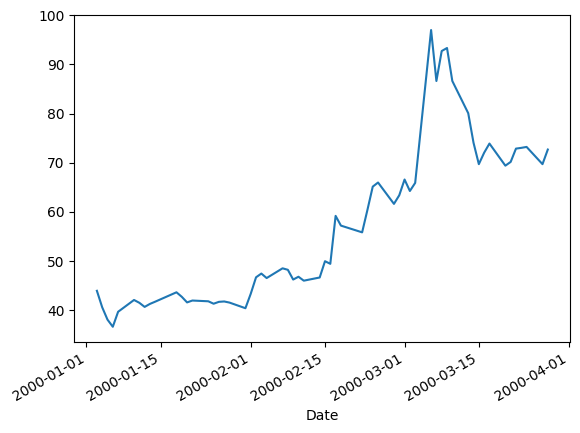

In [10]:
selected_stocks[('Adj Close','A')][0:60].plot()

<Axes: xlabel='Date'>

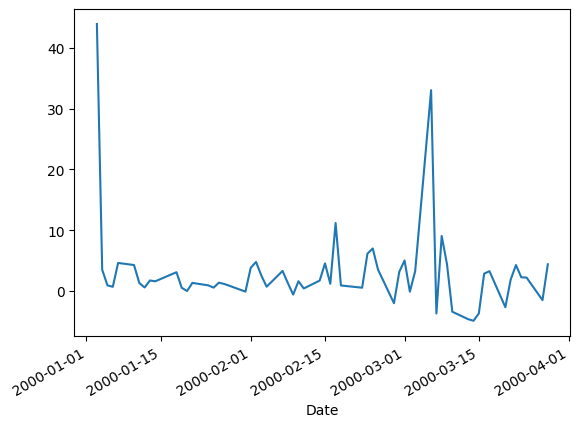

In [11]:
data_frac_adj_close['A'][0:60].plot()

In [12]:
# the LSTM needs data with the format of [samples, time steps, features]
def partition_dataset(seq_length, data):
    x = []
    y = []
    data_len = data.shape[0]

    for i in range(seq_length, data_len):
        _x = data[i-seq_length:i,[-2,-1]]
        _y = data[i, 0] # the first column is the target
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

In [13]:
# function that converts fractionally differentiated predictions into original data
# def inverse_transformation(original_data, predictions, d):
#   k = 10
#   original_predictions = []
  
#   w=[d]
#   for j in range(2,k):
#     w_ =  w[-1] * (d-j+1) / j
#     w.append(w_)
#   w=np.array(w[::-1]) #sort and reshape the w
#   print(original_data.head(50))
#   for i in range(k, len(original_data) + 1):
#     print(np.array(original_data[i-k:i - 1]))
#     original_prediction = predictions[i-k] + np.dot(np.array(original_data[i-k:i - 1]), w)
#     original_predictions.append(original_prediction)
  
#   print(np.array(original_predictions))
#   print(np.array(original_predictions).shape)
#   return np.array(original_predictions)

In [189]:
def train_and_test_split(data, start_year, end_year):
  train_data = data[(data.index.year >= start_year) & (data.index.year <= end_year - 1)]
  test_data = pd.concat([train_data[-42:], data[data.index.year == end_year]], axis = 0)
  return train_data, test_data
  

In [203]:
def predict_returns(train_data, test_data, data_type):

  # Transform the data by standard scaling
  scaler = StandardScaler()
  
  if data_type == 'frac diff':
    features = train_data.loc[:,['Frac Adj Close', 'Volume']].values
    scaler.fit(features)
    train_data_scaled = pd.DataFrame(scaler.transform(features), index = train_data.index)
    test_data_scaled = scaler.transform(test_data.loc[:,['Frac Adj Close', 'Volume']].values)
    test_data_scaled = pd.DataFrame(test_data_scaled, index = test_data.index)

    train_data_scaled = pd.concat([train_data['Returns'], train_data_scaled], axis = 1).values
    test_data_scaled = pd.concat([test_data['Returns'], test_data_scaled], axis = 1).values
  
  else:
    scaler.fit(train_data.values)
    train_data_scaled = scaler.transform(train_data.values)
    test_data_scaled = scaler.transform(test_data.values)

    # Creating a separate scaler that works on a single column for scaling predictions
    scaler_pred = StandardScaler()
    scaler_pred.fit(train_data.iloc[:,0].values.reshape(-1, 1)) # the first column will always contain the variable we
    # want to predict (it can be returns or fractioanlly differentiated prices)

  sequence_length = 42

  # Generate training data and test data
  x_train, y_train = partition_dataset(sequence_length, train_data_scaled)
  x_test, y_test = partition_dataset(sequence_length, test_data_scaled)
  print(x_test)
  print(y_test)

  # Configure the neural network model
  model = Sequential()

  n_neurons = 8
  model.add(LSTM(n_neurons, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2]))) 
  model.add(Dense(4))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mse')

  # Training the model
  epochs = 200
  batch_size = 128
  #early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, min_delta=0.0001)
  history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data = (x_test, y_test),
                    #callbacks = [early_stopping]
                   )
  # Get the predicted values
  y_pred_scaled = model.predict(x_test)

  # Unscale the predicted values
  if data_type != 'frac diff':
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  else:
    y_pred = y_pred_scaled

  # if data_type == "frac diff":
  #   predicted_stock_prices = pd.DataFrame(inverse_transformation(stock_prices, y_pred, frac_order))
  #   predicted_stock_returns = np.log(predicted_stock_prices) - np.log(predicted_stock_prices.shift(1))
  #   print(predicted_stock_returns)
  #   predicted_stock_returns = predicted_stock_returns[1:] # remove the nan value
  #   print(predicted_stock_returns)
  #   y_pred = predicted_stock_returns.values 

  return y_pred

<Axes: xlabel='Date'>

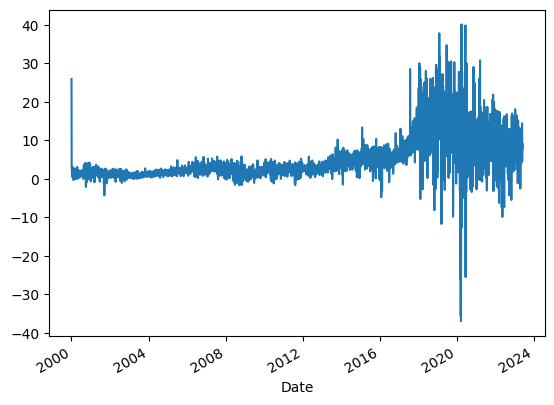

In [16]:
data_frac_adj_close['BA'].plot()

In [213]:
stock_A = pd.concat([stock_returns['BA'], data_volume['BA']], axis = 1)
stock_A.columns = ['Returns', 'Volume']
stock_A.drop(stock_A.index[0], axis = 0, inplace = True)
stock_A.dropna(inplace = True)
stock_A

,Returns,Volume
Date,,
2000-01-04,-0.001557,3592100.0
2000-01-05,0.060442,7631700.0
2000-01-06,0.010212,4922200.0
2000-01-07,0.028615,6008300.0
2000-01-10,-0.014205,2403500.0
...,...,...
2023-05-18,0.001787,4349700.0
2023-05-19,-0.008480,3891500.0
2023-05-22,0.002042,3094300.0


In [214]:
train_data, test_data = train_and_test_split(stock_A, 2000, 2010)

In [215]:
train_data.head(30)

,Returns,Volume
Date,,
2000-01-04,-0.001557,3592100.0
2000-01-05,0.060442,7631700.0
2000-01-06,0.010212,4922200.0
2000-01-07,0.028615,6008300.0
2000-01-10,-0.014205,2403500.0
2000-01-11,-0.018773,2450000.0
2000-01-12,0.004363,2327800.0
2000-01-13,-0.016094,3035100.0
2000-01-14,0.037631,3834900.0


In [216]:
test_data

,Returns,Volume
Date,,
2009-11-02,0.009785,5932500.0
2009-11-03,-0.003528,4899700.0
2009-11-04,0.008146,5082000.0
2009-11-05,0.034754,4916000.0
2009-11-06,-0.001810,3212400.0
...,...,...
2010-12-27,-0.004776,2548500.0
2010-12-28,0.001697,2635100.0
2010-12-29,0.002925,2504700.0


In [217]:
predictions = predict_returns(train_data, test_data, 'returns')

[[[ 4.44462922e-01  4.83454539e-01]
  [-1.72453076e-01  8.84144249e-02]
  [ 3.68538554e-01  1.58143136e-01]
  ...
  [ 4.98178165e-02 -9.57975235e-01]
  [-2.19249551e-01 -8.44374427e-01]
  [-7.14147341e-01 -9.48259879e-01]]

 [[-1.72453076e-01  8.84144249e-02]
  [ 3.68538554e-01  1.58143136e-01]
  [ 1.60154859e+00  9.46490820e-02]
  ...
  [-2.19249551e-01 -8.44374427e-01]
  [-7.14147341e-01 -9.48259879e-01]
  [ 1.71361853e+00  5.80684590e-01]]

 [[ 3.68538554e-01  1.58143136e-01]
  [ 1.60154859e+00  9.46490820e-02]
  [-9.28237713e-02 -5.56968209e-01]
  ...
  [-7.14147341e-01 -9.48259879e-01]
  [ 1.71361853e+00  5.80684590e-01]
  [ 1.48445572e+00  1.60619006e+00]]

 ...

 [[ 2.58393707e-01 -2.09892881e-01]
  [-4.20404587e-01 -5.64656345e-01]
  [-1.14038962e-01 -5.15276331e-01]
  ...
  [ 3.12667860e-01 -5.12407623e-01]
  [-2.30292793e-01 -8.10906176e-01]
  [ 6.96951145e-02 -7.77782169e-01]]

 [[-4.20404587e-01 -5.64656345e-01]
  [-1.14038962e-01 -5.15276331e-01]
  [-4.71518656e-01  6.3924

In [218]:
stock_return = stock_returns['BA'][(stock_returns.index.year == 2010)]

In [219]:
stock_return

Date
2010-01-04    0.037172
2010-01-05    0.032227
2010-01-06    0.029883
2010-01-07    0.039684
2010-01-08   -0.009693
                ...   
2010-12-27   -0.004776
2010-12-28    0.001697
2010-12-29    0.002925
2010-12-30   -0.000615
2010-12-31    0.003838
Name: BA, Length: 252, dtype: float64

In [220]:
predictions.shape

(252, 1)

In [221]:
stock_return

Date
2010-01-04    0.037172
2010-01-05    0.032227
2010-01-06    0.029883
2010-01-07    0.039684
2010-01-08   -0.009693
                ...   
2010-12-27   -0.004776
2010-12-28    0.001697
2010-12-29    0.002925
2010-12-30   -0.000615
2010-12-31    0.003838
Name: BA, Length: 252, dtype: float64

In [222]:
predic = pd.DataFrame(predictions, index = stock_return.index)
predic

,0
Date,
2010-01-04,-0.008843
2010-01-05,-0.009816
2010-01-06,-0.008117
2010-01-07,-0.008897
2010-01-08,-0.010743
...,...
2010-12-27,0.001072
2010-12-28,0.000410
2010-12-29,0.002066


In [223]:
np.corrcoef(stock_return, predic.values.reshape(-1))

array([[1.        , 0.05971186],
       [0.05971186, 1.        ]])

In [224]:
r2_score(stock_return, predic.values.reshape(-1))

-0.03564103307278832

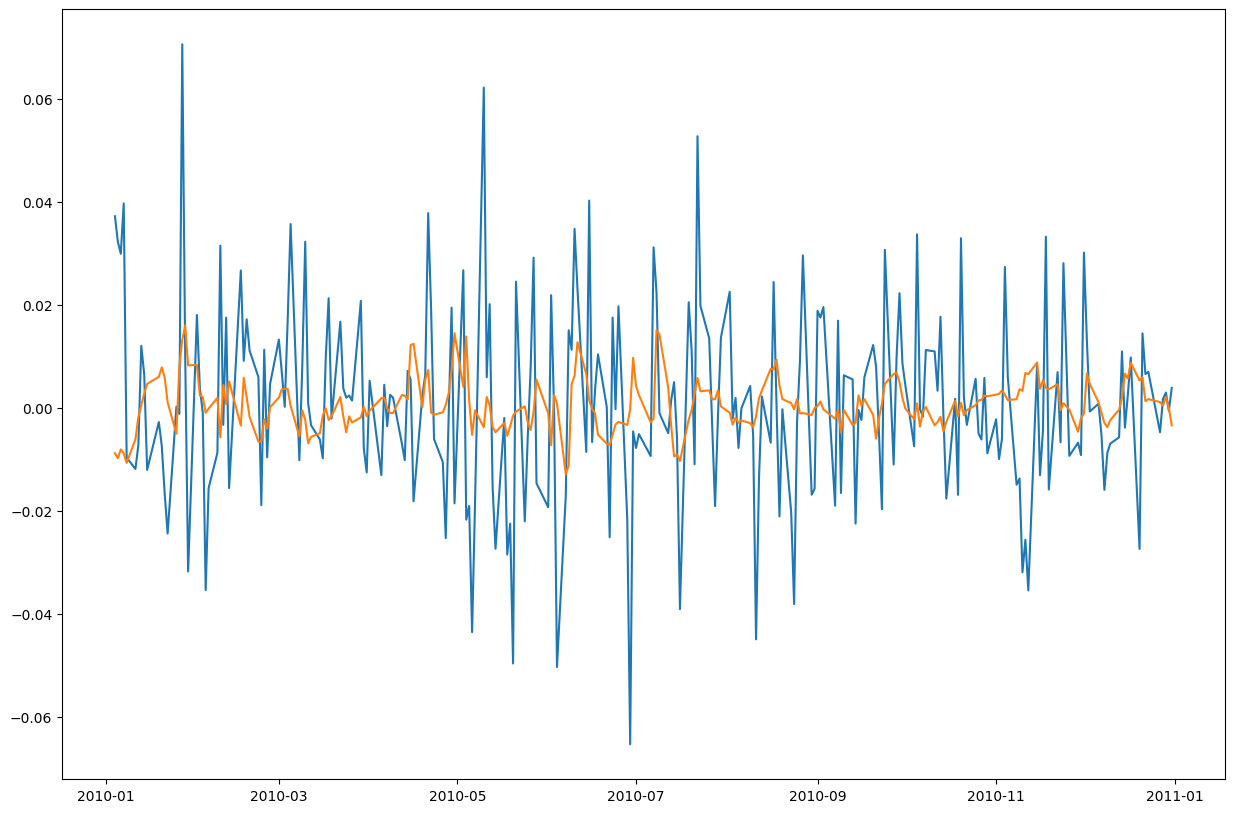

In [226]:
plt.figure(figsize = (15,10))
plt.plot(stock_return.index, stock_return)
plt.plot(stock_return.index, predic)

# Long / Short Portfolio Construction